# イベルメクチン論文の図の再現

* 黒木玄
* 2022-04-02

$
\newcommand\op{\operatorname}
$

* Gilmar Reis, M.D., Ph.D., Eduardo A.S.M. Silva, M.D., Ph.D., Daniela C.M. Silva, M.D., Ph.D., Lehana Thabane, Ph.D., Aline C. Milagres, R.N., Thiago S. Ferreira, M.D., Castilho V.Q. dos Santos, Vitoria H.S. Campos, Ana M.R. Nogueira, M.D., Ana P.F.G. de Almeida, M.D., Eduardo D. Callegari, M.D., Adhemar D.F. Neto, M.D., Ph.D., et al., for the TOGETHER Investigators. Effect of Early Treatment with Ivermectin among Patients with Covid-19. New England Journal of Medicine, March 30, 2022
DOI: 10.1056/NEJMoa2115869 \[[html](https://www.nejm.org/doi/full/10.1056/NEJMoa2115869)\] \[[pdf](https://www.nejm.org/doi/pdf/10.1056/NEJMoa2115869?articleTools=true)\]

In [1]:
using Distributions
using StatsPlots
default(fmt = :png, titlefontsize=12)
using KernelDensity
using Printf
using Roots
using QuadGK

## Supplementary Appendix Figure S6 の再現

* Supplementary Appendix \[[pdf](https://www.nejm.org/doi/suppl/10.1056/NEJMoa2115869/suppl_file/nejmoa2115869_appendix.pdf)\]

のp.15のFigure S6の再現. データは[論文](https://www.nejm.org/doi/full/10.1056/NEJMoa2115869)のTable 2より.

In [2]:
# Ivermectin  a b
# Placebo     c d

function pdfRR(beta1, beta2, ρ)
    f(q) = exp(logpdf(beta1, ρ*q) + log(q) + logpdf(beta2, q)) 
    if 0 < ρ ≤ 1
        quadgk(f, 0, 1)[1]
    elseif ρ > 1
        quadgk(f, 0, 1/ρ)[1]
    else
        zero(ρ)
    end
end

function cdfRR(beta1, beta2, ρ)
    if 0 < ρ ≤ 1
        f(p) = exp(logpdf(beta1, p) + logccdf(beta2, p/ρ))
        quadgk(f, 0, ρ)[1]
    elseif ρ > 1
        g(q) = exp(logpdf(beta2, q) + logccdf(beta1, ρ*q))
        1 - quadgk(g, 0, 1/ρ)[1]
    else
        zero(ρ)
    end
end

function bayesian_binomial(A;
        α = 1.0, β = 1.0,
        alpha = 0.05,
        nsims = 10^6,
        title = "",
        ERlim = (0.1, 0.25),
        RRlim = (0.5, 2.5),
        ERtick = 0:0.025:1,
        RRtick = 0:0.25:10,
    )
    a, b, c, d = A'
    beta1 = Beta(α + a, β + b)
    beta2 = Beta(α + c, β + d)
    
    if nsims == 0
        lw = 1
        L = find_zero(ρ -> cdfRR(beta1, beta2, ρ) - alpha/2, 1.0)
        M = find_zero(ρ -> cdfRR(beta1, beta2, ρ) - 0.5, 1.0)
        U = find_zero(ρ -> cdfRR(beta1, beta2, ρ) - (1 - alpha/2), 1.0)
        f = ρ -> pdfRR(beta1, beta2, ρ)
    else
        lw = 2
        R1, R2 = rand(beta1, nsims), rand(beta2, nsims)
        RR = R1 ./ R2
        L, M, U = quantile.(Ref(RR), (alpha/2, 0.5, 1 - alpha/2))
        ik = InterpKDE(kde(RR))
        f = ρ -> pdf(ik, ρ)
    end
    Lstr = @sprintf "%.2f" L
    Mstr = @sprintf "%.2f" M
    Ustr = @sprintf "%.2f" U
    BCIstr = "RR [BCI]: $Mstr [$Lstr, $Ustr]"
     
    P1 = plot(; title)
    plot!(x -> pdf(beta1, x), ERlim...; c=:red, label="Ivermectin")
    plot!(x -> pdf(beta2, x), ERlim...; c=:blue, label="Placebo")
    plot!(; xlabel="Event rate", ylabel="Posterior Density")
    plot!(; xtick = ERtick)
    
    P2 = plot(; title = "$BCIstr")
    plot!(f, L, U; c=:black, lw, label="", fillrange=0, fillcolor=:cyan)
    plot!(f, first(RRlim), L; c=:black, lw, label="", fillrange=0, fillcolor=:red)
    plot!(f, U, last(RRlim);  c=:black, lw, label="", fillrange=0, fillcolor=:red)
    plot!(; xlabel="Relative risk", ylabel="Posterior Density")
    plot!(; xtick = RRtick)
    
    plot(P1, P2; size=(1000, 300))
    plot!(; leftmargin=5Plots.mm, bottommargin=5Plots.mm)
end

bayesian_binomial (generic function with 1 method)

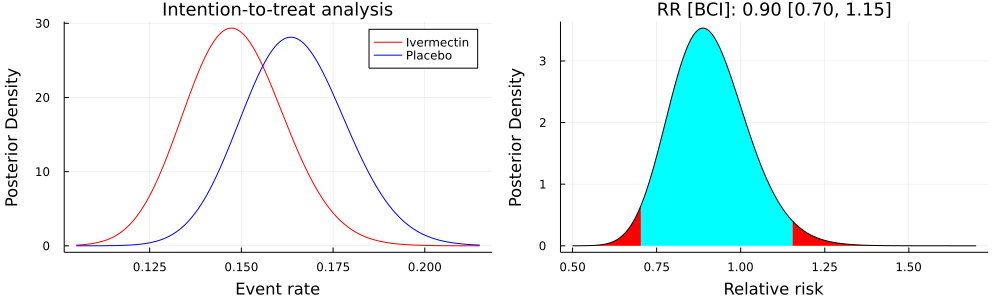

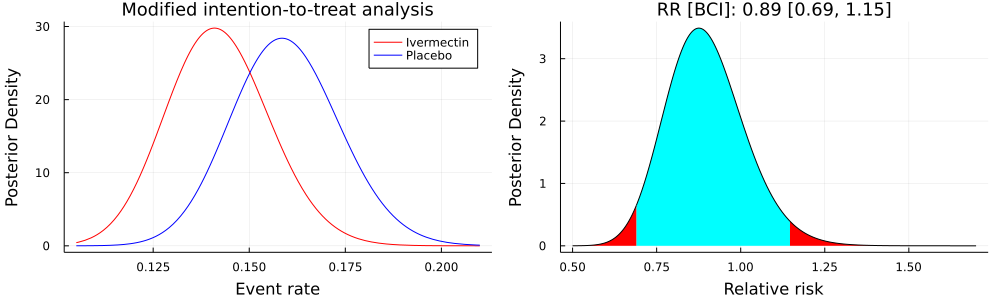

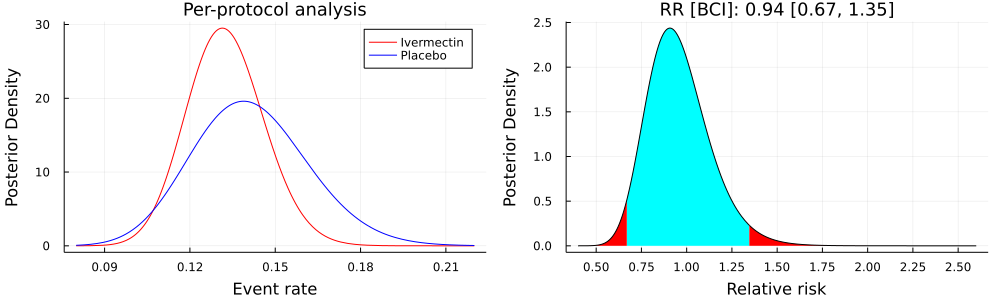

In [3]:
nsims = 0

bayesian_binomial([100 679-100; 111 679-111]; nsims,
    title = "Intention-to-treat analysis",
    ERlim = (0.105, 0.215), RRlim = (0.50, 1.70),
) |> display

bayesian_binomial([95 674-95; 107 675-107]; nsims,
    title = "Modified intention-to-treat analysis",
    ERlim = (0.105, 0.21), RRlim = (0.50, 1.70),
) |> display

bayesian_binomial([82 624-82; 40 288-40]; nsims,
    title = "Per-protocol analysis",
    ERlim = (0.08, 0.22), RRlim = (0.40, 2.60), ERtick = 0:0.03:1,
) |> display

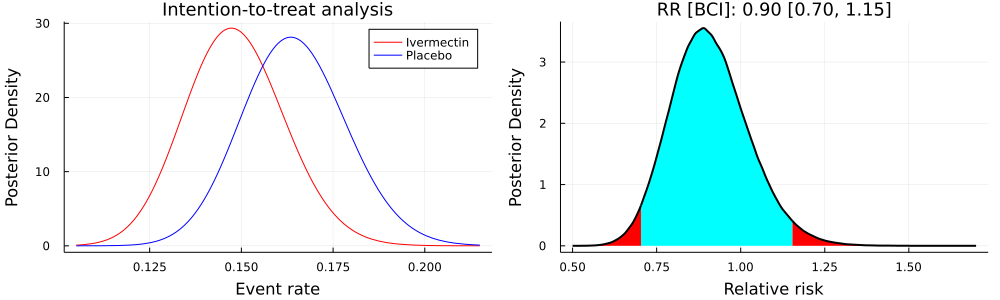

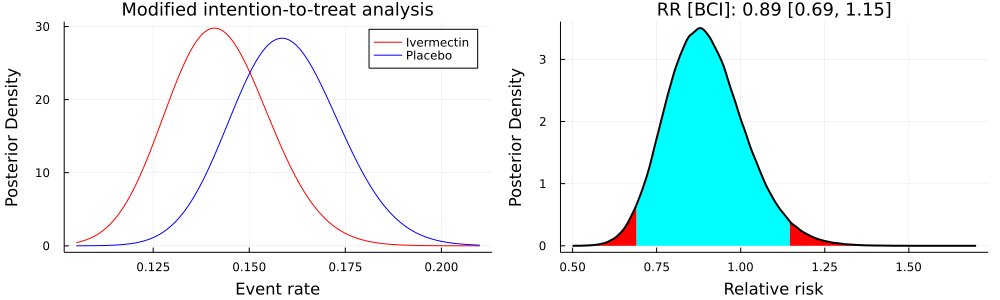

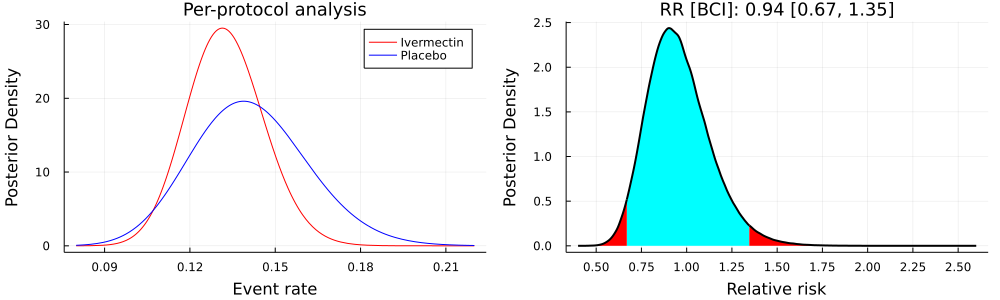

In [4]:
nsims = 10^6

bayesian_binomial([100 679-100; 111 679-111]; nsims,
    title = "Intention-to-treat analysis",
    ERlim = (0.105, 0.215), RRlim = (0.50, 1.70),
) |> display

bayesian_binomial([95 674-95; 107 675-107]; nsims,
    title = "Modified intention-to-treat analysis",
    ERlim = (0.105, 0.21), RRlim = (0.50, 1.70),
) |> display

bayesian_binomial([82 624-82; 40 288-40]; nsims,
    title = "Per-protocol analysis",
    ERlim = (0.08, 0.22), RRlim = (0.40, 2.60), ERtick = 0:0.03:1,
) |> display

## P値版のグラフ

In [5]:
# Ivermectin  a b
# Placebo     c d

safediv(x, y) = x == 0 ? x/one(y) : x/y
safesqrt(x) = √max(0, x)

riskratio(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
riskratio(A) = riskratio(A'...)

"""
Δ = Delta(a, b, c, d, ρ) is characterized by ((a - Δ)(c + Δ + d))/((a - Δ + b)(c + Δ)) = ρ.
"""
function Delta(a, b, c, d, ρ)
    m, n = a + b, c + d
    A, B, C = 1 - ρ, n - a + ρ*(m - c), -a*n + ρ*m*c
    safediv(2C, -B - safesqrt(B^2 - 4A*C))
end
Delta(A, ρ) = Delta(A'..., ρ)

"""estimator of var(Δ)"""
function varDelta(a, b, c, d, ρ)
    Δ = Delta(a, b, c, d, ρ)
    1/(1/(a - Δ) - 1/(a + b - Δ) + 1/(c + Δ) - 1/(c + d + Δ))
end
varDelta(A::AbstractVecOrMat, ρ) = varDelta(A'..., ρ)

chisq_RR(A, ρ = 1.0) = safediv(Delta(A, ρ)^2, varDelta(A, ρ))

"""chi-squared P-value function of relatice risk"""
pvalue_chisq_RR(A, ρ = 1.0) = ccdf(Chisq(1), chisq_RR(A, ρ))

"""chi-squared confidence interval of relatice risk"""
function ci_chisq_RR(A, α = 0.05)
    f(t) = pvalue_chisq_RR(A, exp(t)) - α
    logci = find_zeros(f, -1e1, 1e1)
    exp(first(logci)), exp(last(logci))
end

"""Clopper-Pearson P-value function of binomial distribution model"""
function pvalue_clopper_pearson(a, b, p)
    bin = Binomial(a + b, p)
    min(1, 2cdf(bin, a), 2ccdf(bin, a-1))
end

"""chi-squared P-value function of binomial distribution model"""
function pvalue_chisq_bin(a, b, p)
    m = a + b
    chisq = safediv((a - m*p)^2, m*p*(1 - p))
    ccdf(Chisq(1), chisq)
end

function chisq_test_RR(A; RR₀ = 1.0, alpha = 0.05)
    RR = riskratio(A)
    chisq = chisq_RR(A, RR₀)
    df = 1
    p_value = ccdf(Chisq(df), chisq)
    conf_int = ci_chisq_RR(A, alpha)
    (; RR, RR₀, p_value, alpha, conf_int, chisq, df)
end

function plot_chisq_test(A; RR₀ = 1.0, alpha = 0.05,
        title = "",
        ERlim = (0.1, 0.25),
        RRlim = (0.5, 2.5),
        ERtick = 0:0.025:1,
        RRtick = 0:0.25:10,
        pvalue_bin = pvalue_chisq_bin,
    )
    (; RR, RR₀, p_value, alpha, conf_int, chisq, df) = chisq_test_RR(A; RR₀, alpha)
    a, b, c, d = A'
    
    f(p) = pvalue_bin(a, b, p)
    g(q) = pvalue_bin(c, d, q)
    
    h(RR) = pvalue_chisq_RR(A, RR)
    L, U = conf_int
    Lstr = @sprintf "%.2f" L
    RRstr = @sprintf "%.2f" RR
    Ustr = @sprintf "%.2f" U
    CIstr = "RR [CI]: $RRstr [$Lstr, $Ustr]"
    
    P1 = plot(; title)
    plot!(f, ERlim...; c=:red, label="Ivermectin")
    plot!(g, ERlim...; c=:blue, label="Placebo")
    plot!(; xlabel="Event rate", ylabel="P-value")
    plot!(; xtick = ERtick, ytick=0:0.1:1)
    
    P2 = plot(; title = "$CIstr")
    plot!(h, RRlim...; c=:black, label="")
    plot!([L, U], [alpha, alpha]; c=:red, lw=4, label="")
    plot!(; xlabel="Relative risk", ylabel="P-value")
    plot!(; xtick = RRtick, ytick=0:0.1:1)
    
    plot(P1, P2; size=(1000, 300))
    plot!(; leftmargin=5Plots.mm, bottommargin=5Plots.mm)
end


plot_chisq_test (generic function with 1 method)

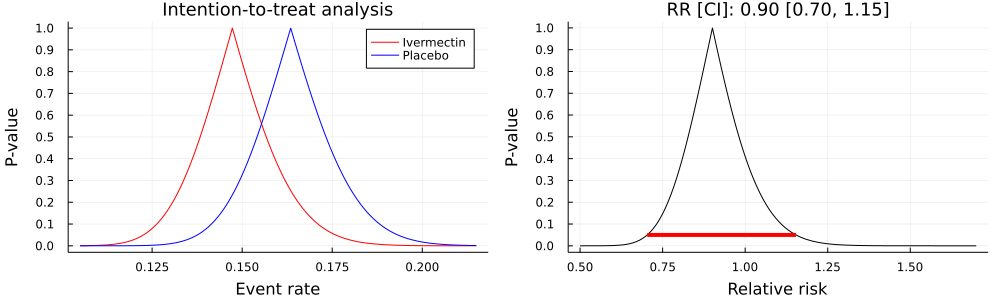

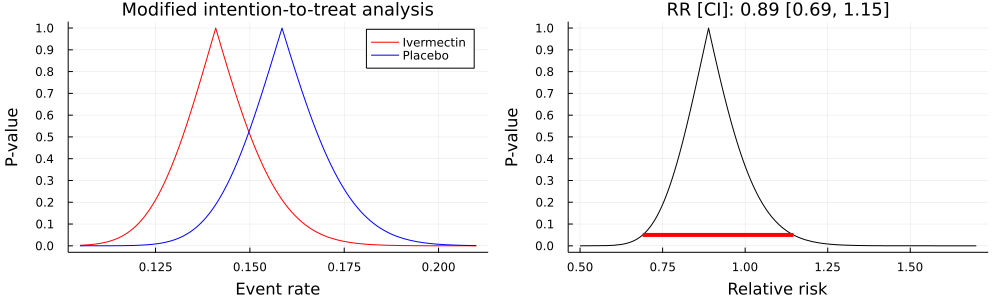

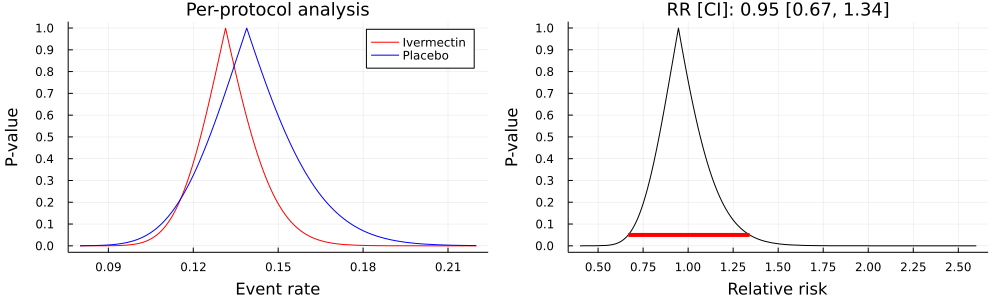

In [6]:
pvalue_bin = pvalue_chisq_bin

plot_chisq_test([100 679-100; 111 679-111]; pvalue_bin,
    title = "Intention-to-treat analysis",
    ERlim = (0.105, 0.215), RRlim = (0.50, 1.70),
) |> display

plot_chisq_test([95 674-95; 107 675-107]; pvalue_bin,
    title = "Modified intention-to-treat analysis",
    ERlim = (0.105, 0.21), RRlim = (0.50, 1.70),
) |> display

plot_chisq_test([82 624-82; 40 288-40]; pvalue_bin,
    title = "Per-protocol analysis",
    ERlim = (0.08, 0.22), RRlim = (0.40, 2.60), ERtick = 0:0.03:1,
) |> display

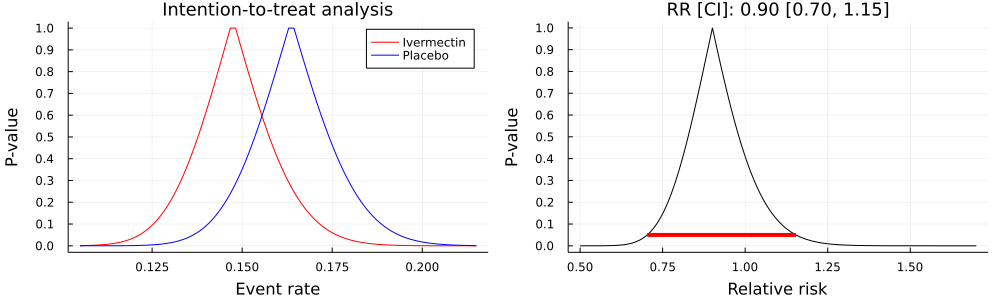

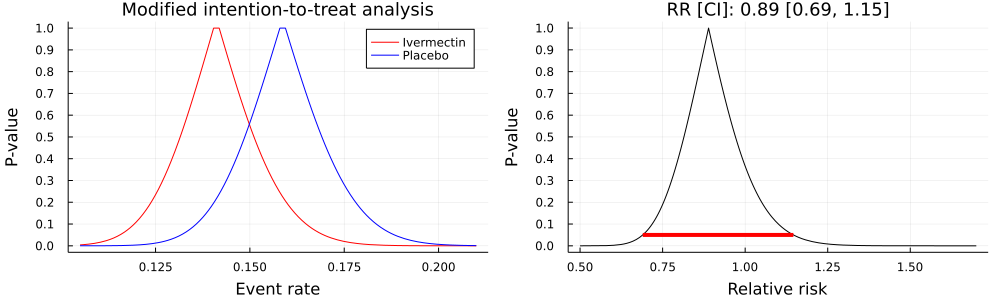

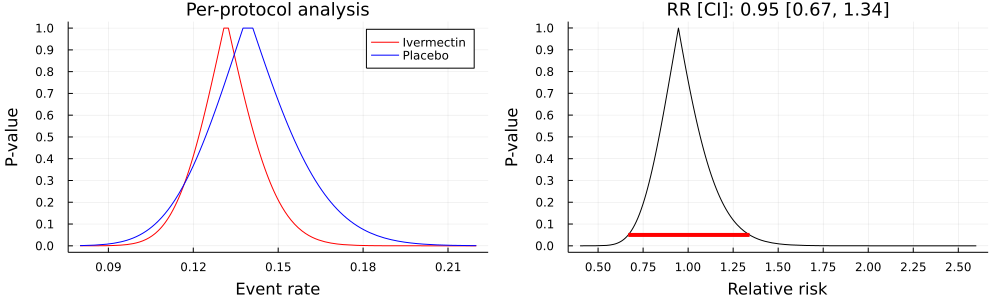

In [7]:
pvalue_bin = pvalue_clopper_pearson

plot_chisq_test([100 679-100; 111 679-111]; pvalue_bin,
    title = "Intention-to-treat analysis",
    ERlim = (0.105, 0.215), RRlim = (0.50, 1.70),
) |> display

plot_chisq_test([95 674-95; 107 675-107]; pvalue_bin,
    title = "Modified intention-to-treat analysis",
    ERlim = (0.105, 0.21), RRlim = (0.50, 1.70),
) |> display

plot_chisq_test([82 624-82; 40 288-40]; pvalue_bin,
    title = "Per-protocol analysis",
    ERlim = (0.08, 0.22), RRlim = (0.40, 2.60), ERtick = 0:0.03:1,
) |> display

## 二項分布モデルでの事後分布とP値の関係

各々が $[0,1]$ 区間上の一様分布に同分布確率変数達 $T_1, T_2, \ldots, T_n$ を考える. 

$T_1, T_2, \ldots, T_n$ の中で $k$ 番目に大きな値を $T_{(k)}$ と書く(順序統計量).  このとき, $T_{(k)}$ も確率変数になり,

$$
T_{(1)} \le T_{(2)} \le \cdots \le T_{(n)}
$$

を満たしている.  $T_{(k)}$ の累積確率函数と確率密度函数を求めよう.  $0\le p\le 1$ であると仮定する.

### 累積確率函数

$T_{(k)}\le p$ となる確率は $T_1,\ldots,T_n$ の中で $p$ 以下のものが $k$ 個以上である確率である.

$T_1,\ldots,T_n$ の中で $p$ 以下のものがちょうど $j$ 個である確率は $\binom{n}{j} p^j (1 - p)^{n-j}$ になるので, 

$$
P(T_{(k)} \le p) = \sum_{j=k}^n \binom{n}{j} p^j (1 - p)^{n-j}.
$$

ゆえに $B_{n,p}$ を試行回数 $n$, 成功確率 $p$ の二項分布に従う確率変数だとすると,

$$
P(T_{(k)} \le p) = P(B_{n,p} \ge k)
$$

これより, 以下も得られる:

$$
P(T_{(k+1)} \le p) = P(B_{n,p} \ge k+1), \quad
P(T_{(k+1)} \ge p) = P(B_{n,p} \le k), \quad
$$

### 確率密度函数

$T_{(k)} \in [t, t+dt]$ となる確率は近似的に

$$
\begin{aligned}
p_k(t)\,dt &=
\frac{n!}{(k-1)!1!(n-k)!} t^{k-1}\, dt\, (1 - t)^{n-k}
\\ &=
\frac{\Gamma(n+1)}{\Gamma(k)\Gamma(n-k+1)} t^{k-1}(1 - t)^{n-k}\,dt =
\frac{t^{k-1}(1 - t)^{n-k}}{B(k, n-k+1)}\,dt
\end{aligned}
$$

$n!/((k-1)!1!(n-k)!)$ は $1,2,\dots,n$ を $k-1$ 個, $1$ 個, $n-k$ 個のグループに分ける方法の個数(多項係数の特別な場合)である.  $T_{(k)} \approx t$ となるとき, $k-1$ 個の $T_i$ は $p$ 未満になり, $n-k$ 個の $T_i$ は $p$ より大きいと考えてよい.  

この結果は $T_{(k)}$ がパラメータ $(k, n-k+1)$ のベータ分布に従うことを意味している.

### 二項分布とベータ分布の関係

$P(T_{(k)} \le p) = P(B_{n,p} \ge k)$ は, パラメータが $(k, n-k+1)$ のベータ分布で $p$ 以下になる確率が, 試行回数 $n$, 成功確率 $p$ の二項分布で $k$ 以上になる確率に一致していることを意味している.

$P(T_{(k+1)} \ge p) = P(B_{n,p} \le k)$ は, パラメータ $(k+1, n-k)$ のベータ分布で $p$ 以上になる確率が, 試行回数 $n$, 成功確率 $p$ の二項分布で $k$ 以下になる確率に一致していることを意味している.

以上の結果を積分と和で書くと,

$$
\begin{aligned}
&
\int_0^p \frac{t^{k-1}(1 - t)^{n-k}}{B(k, n-k+1)}\,dt =
\sum_{j=k}^n \binom{n}{j} p^j (1 - p)^{n-j},
\\ &
\int_p^1 \frac{t^k(1 - t)^{n-k-1}}{B(k+1, n-k)}\,dt =
\sum_{j=0}^k \binom{n}{j} p^j (1 - p)^{n-j}.
\end{aligned}
$$

このような二項分布とベータ分布の関係は二項検定に付随するClopper-Pearsonの信頼区間の効率的な計算で使われている.

### 二項分布モデルのベイズ統計とP値の関係

ベータ分布 $\op{Beta}(k, n-k+1)$ は二項分布モデルのベイズ統計におけるimproper共役事前分布 $\op{Beta}(0, 1)$ の事後分布に等しい. 

そして, 前節の結果より, その事後分布 $\op{Beta}(k, n-k+1)$ で生成される成功確率が $p$ 以下になる確率は, 二項分布 $\op{Binomial}(n, p)$ で生成される成功回数が $k$ 以上になる確率に一致する.

二項分布 $\op{Binomial}(n, p)$ で生成される成功回数が $k$ 以上になる確率は「成功確率は $p$ 以下である」という帰無仮説の片側検定のP値に等しい.

以上によって, ベイズ統計側で事前分布としてimproper共役事前分布 $\op{Beta}(0, 1)$ を採用すれば, 事後分布において「成功確率は $p$ 以下である」という仮説が成立する確率と「成功確率は $p$ 以下である」という帰無仮説の片側検定のP値がぴったり等しくなることがわかった.

以下の議論は以上の議論の繰り返しである.
 
ベータ分布 $\op{Beta}(k+1, n-k)$ は二項分布モデルのベイズ統計におけるimproper共役事前分布 $\op{Beta}(1, 0)$ の事後分布に等しい. 

そして, 前節の結果より, その事後分布 $\op{Beta}(k+1, n-k)$ で生成される成功確率が $p$ 以上になる確率は, 二項分布 $\op{Binomial}(n, p)$ で生成される成功回数が $k$ 以下になる確率に一致する.

二項分布 $\op{Binomial}(n, p)$ で生成される成功回数が $k$ 以下になる確率は「成功確率は $p$ 以上である」という帰無仮説の片側検定のP値に等しい.

以上によって, ベイズ統計側で事前分布としてimproper共役事前分布 $\op{Beta}(1, 0)$ を採用すれば, 事後分布において「成功確率は $p$ 以上である」という仮説が成立する確率と「成功確率は $p$ 以上である」という帰無仮説の片側検定のP値がぴったり等しくなることがわかった.

まとめ:

* (improper共役事前分布 $\op{Beta}(0, 1)$ の事後分布において「成功確率は $p$ 以下である」という仮説が成立する確率) = (「成功確率は $p$ 以下である」という帰無仮説の片側検定の $P$ 値)
* (improper共役事前分布 $\op{Beta}(1, 0)$ の事後分布において「成功確率は $p$ 以上である」という仮説が成立する確率) = (「成功確率は $p$ 以上である」という帰無仮説の片側検定の $P$ 値)

これらの公式はぴったり誤差無しで成立している.

任意の共役事前分布 $\op{Beta}(\alpha, \beta)$ の事後分布 $\op{Beta}(\alpha + k, \beta + n-k)$ は $n$ と $k$ が十分に大きければ以上で登場した $\op{Beta}(k, n-k+1)$ や $\op{Beta}(k+1, n-k)$ との違いは小さくなる.  その違いは $(\alpha, \beta)$ が $(0, 1)$ や $(1, 0)$ に近い方が小さくなる.

一様事前分布は $\op{Beta}(\alpha, \beta) = \op{Beta}(1, 1)$ の場合であり, $(\alpha, \beta)=(1,1)$ は $(0,1)$, $(1,0)$ に近い.  だから, $k$, $n$ を非常に大きくしなくても, 共役事前分布 $\op{Beta}(\alpha, \beta)$ の事後分布 $\op{Beta}(\alpha + k, \beta + n-k)$ は $\op{Beta}(k, n-k+1)$ や $\op{Beta}(k+1, n-k)$ に近い分布になる.

両側検定のP値は片側検定のP値を2倍したり2つ足し合わせたものになると考えてよい. このことから, 両側検定のP値も事後分布における確率で近似的に表現できることがわかる.

このように二項分布モデルのようなシンプルなベイズ統計とP値を使う方法の違いは非常に小さい.